# Installing Dependencies and Imports

In [ ]:
#pip install requests beautifulsoup4 pandas fpdf
#!pip install panel
#!pip install langchain
#!pip install -U langchain-community
#!pip install pypdf
#!pip install docarray
#!pip install chromadb
#!pip install -U langchain-openai
#!pip install --upgrade jupyterlab panel
# !pip install sentence-transformers scikit-learn
# !pip install jupyter_bokeh

In [1]:
import os
import sys
import json
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import openai
from bs4 import BeautifulSoup
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chains import RetrievalQA, ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import panel as pn  # GUI
pn.extension()
import param
import unittest

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress depreciation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load environment variables
_ = load_dotenv(find_dotenv())
openai.api_key = os.environ['OPENAI_API_KEY']
llm_name = "gpt-3.5-turbo"

/opt/anaconda3/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Knowledge Base Generation

Scraping the crop informations from [Plant Village](https://plantvillage.psu.edu/)  and save to json

In [ ]:
# Define the URLs for different plants
urls = {
    "beans": "https://plantvillage.psu.edu/topics/bean/infos#diseases",
    "mango": "https://plantvillage.psu.edu/topics/mango/infos#diseases",
    "cocoa": "https://plantvillage.psu.edu/topics/cocoa-cacao/infos#diseases",
    "okra": "https://plantvillage.psu.edu/topics/okra/infos#diseases",
    "oil palm": "https://plantvillage.psu.edu/topics/oil-palm/infos#diseases",
    "onion": "https://plantvillage.psu.edu/topics/onion/infos#diseases",
    "almond": "https://plantvillage.psu.edu/topics/almond/infos#diseases",
    "carrot": "https://plantvillage.psu.edu/topics/carrot/infos#diseases",
    "ginger": "https://plantvillage.psu.edu/topics/ginger/infos#diseases",
    "orange": "https://plantvillage.psu.edu/topics/orange/infos#diseases",
    "pawpaw": "https://plantvillage.psu.edu/topics/papaya-pawpaw/infos#diseases",
    "plantain": "https://plantvillage.psu.edu/topics/plantain/infos#diseases",
    "rice": "https://plantvillage.psu.edu/topics/rice/infos#diseases"
}

In [ ]:
# Function to extract data from URLs and generate a JSON structure
def generate_kbs_json():
    session = requests.Session()
    all_plants = []

    for plant, url in urls.items():
        print("=" * 10, f"Generating Knowledge Base for {plant}", "=" * 10)

        try:
            res = session.get(url)
            res.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}. Skipping to the next plant.")
            continue

        bs = BeautifulSoup(res.text, 'html.parser')

        # Set to keep track of encountered disease names
        encountered_diseases = set()

        # List to store diseases for the current plant
        diseases = []

        for tag in bs.find_all('h4'):
            disease_tag = tag.text.strip()
            if not disease_tag:
                continue

            try:
                disease_name = tag.find_next('span', {'style': 'font-weight:400;font-size:80%;'}).previous_sibling.strip()
                botanical_name = tag.find_next('i').text.strip()
                symptoms = tag.find_next('div', {'class': 'symptoms'}).text.strip()
                cause = tag.find_next('div', {'class': 'cause'}).text.strip()
                comments = tag.find_next('div', {'class': 'comments'}).text.strip()

                management_section = tag.find_next('div', class_='management')
                management_heading = management_section.find('h5').text.strip()
                management = management_section.text.replace(management_heading, '').strip()

                # Skip if the disease name has already been encountered for this plant
                if disease_name in encountered_diseases:
                    continue

                # Add the disease to the list for the current plant
                diseases.append({
                    "disease_name": disease_name,
                    "botanical_name": botanical_name,
                    "symptoms": symptoms,
                    "cause": cause,
                    "comments": comments,
                    "management": management
                })

                # Add the disease name to the set of encountered names
                encountered_diseases.add(disease_name)

            except AttributeError as e:
                continue

        # Add the plant and its diseases to the all_plants list
        all_plants.append({
            "name": plant.capitalize(),
            "diseases": diseases
        })

    # Write the JSON to a file
    with open('knowledge_base.json', 'w', encoding='utf-8') as f:
        json.dump({"plants": all_plants}, f, ensure_ascii=False, indent=4)

    print("JSON file saved as knowledge_base.json")


In [ ]:
generate_kbs_json()


#### ...KBS generation process completed!

==============================

# Inference Engine

Basic workflow for retrieval augmented generation (RAG):

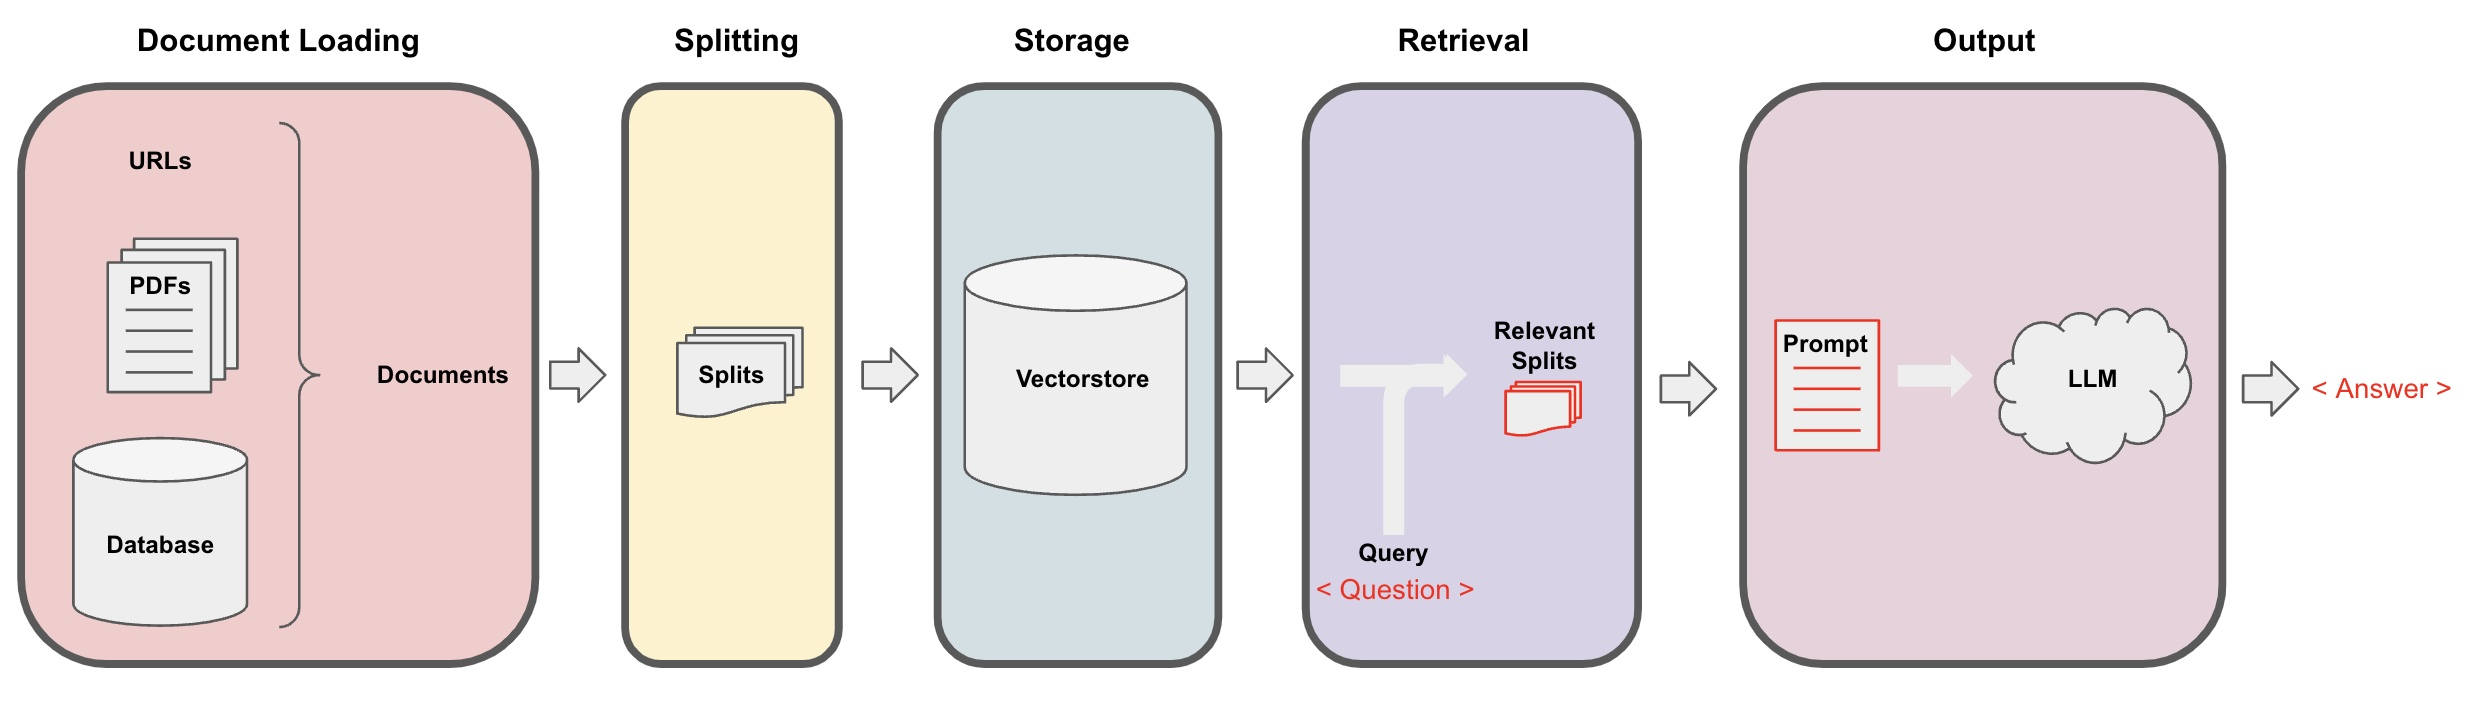

This includes `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

The `Retrieval` is used for output generation in Q+A using `RetrievalQA` chain.

The memory and retriever models can be alternated by changing the configuration in `load_db` function and the `convchain` method.

In [2]:
# Function to load and process JSON data
def load_db(file, chain_type, k):
    # Load JSON data
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    # Convert JSON data to string for processing
    documents = []
    for plant in json_data["plants"]:
        plant_name = plant["name"]
        for disease in plant["diseases"]:
            text = (
                f"Plant: {plant_name}\n"
                f"Disease Name: {disease['disease_name']}\n"
                f"Botanical Name: {disease['botanical_name']}\n"
                f"Symptoms: {disease['symptoms']}\n"
                f"Cause: {disease['cause']}\n"
                f"Comments: {disease['comments']}\n"
                f"Management: {disease['management']}\n"
            )
            documents.append(text)

    # Split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.create_documents(documents)

    # Define embedding
    embeddings = OpenAIEmbeddings()

    # Create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)

    # Define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})

    # Create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0),
        chain_type=chain_type,
        retriever=retriever,
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa

In [3]:
class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query = param.String("")
    db_response = param.List([])

    def __init__(self, **params):
        super(cbfs, self).__init__(**params)
        self.panels = []
        self.loaded_file = "knowledge_base.json"  # Default JSON file
        self.qa = load_db(self.loaded_file, "stuff", 4)

    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.json")  # Save local copy of JSON file
            self.loaded_file = file_input.filename
            button_load.button_style = "outline"
            self.qa = load_db("temp.json", "stuff", 4)
            button_load.button_style = "solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer']

        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('Response:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  # Clears loading indicator when cleared
        return pn.WidgetBox(*self.panels, scroll=True)

    @param.depends('db_query')
    def get_lquest(self):
        if not self.db_query:
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("No DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query)
        )

    @param.depends('db_response')
    def get_sources(self):
        if not self.db_response:
            return
        rlist = [pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history')
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist = [pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self, count=0):
        self.chat_history = []
        return

# GUI

The expert system interface where user interaction.

[Panel](https://panel.holoviz.org/) and [Param](https://param.holoviz.org/) have many useful features and widgets you can use to extend the GUI.

In [5]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.json')  # Accept only JSON files
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput(placeholder='Enter your query here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp)

jpg_pane = pn.pane.Image('convolangchain.jpeg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation, loading_indicator=True, height=400),
    pn.layout.Divider(),
)
tab2 = pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources),
)
tab3 = pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4 = pn.Column(
    pn.Row(file_input, button_load, bound_button_load),
    pn.Row(button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic")),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# Crop Disease Diagnosis and Management System')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3), ('Configure', tab4))
)
dashboard

BokehModel(combine_events=True, render_bundle={'docs_json': {'5f414719-c033-41d4-aa65-e5f2dc31e14d': {'version…

## Performance Functiinality Testing

In [6]:
class CustomTestResult(unittest.TestResult):
    def startTest(self, test):
        self._start_time = time.time()
        super().startTest(test)

    def addSuccess(self, test):
        elapsed = time.time() - self._start_time
        print(f"{test._testMethodName}: OK (Time: {elapsed:.4f}s)")
        super().addSuccess(test)

    def addFailure(self, test, err):
        elapsed = time.time() - self._start_time
        print(f"{test._testMethodName}: FAIL (Time: {elapsed:.4f}s)")
        super().addFailure(test, err)

    def addError(self, test, err):
        elapsed = time.time() - self._start_time
        print(f"{test._testMethodName}: ERROR (Time: {elapsed:.4f}s)")
        super().addError(test, err)

class TestExpertSystem(unittest.TestCase):

    def setUp(self):
        # Initialize the expert system object
        self.cb = cbfs()

    def test_symptom_matching(self):
        # Test the system's ability to match symptoms
        self.cb.call_load_db(0)
        query = "What disease causes yellow leaves in beans?"
        response_panel = self.cb.convchain(query)
        self.assertIn('yellow', self.cb.db_query.lower(), "The generated DB query should relate to yellow leaves")
        self.assertGreater(len(self.cb.db_response), 0, "Should return at least one source document")
        self.assertIn('leaves', self.cb.answer.lower(), "The response should mention leaves")

    def test_database_query_generation(self):
        # Test the system's query generation
        query = "Why are the mango leaves turning brown?"
        self.cb.convchain(query)
        self.assertIn('mango', self.cb.db_query.lower(), "The generated DB query should include mango")
        self.assertIn('brown', self.cb.db_query.lower(), "The generated DB query should include brown")

    def test_response_generation(self):
        # Test the generation of a response based on a query
        query = "Why do onions have black spots?"
        response_panel = self.cb.convchain(query)
        self.assertIn('black spots', self.cb.answer.lower(), "The response should mention black spots")
        self.assertGreater(len(self.cb.answer), 0, "Generated response should not be empty")

    def test_clear_history(self):
        # Test the clearing of chat history
        query = "What is the disease affecting beans?"
        self.cb.convchain(query)
        self.assertGreater(len(self.cb.chat_history), 0, "Chat history should contain at least one entry")
        self.cb.clr_history()
        self.assertEqual(len(self.cb.chat_history), 0, "Chat history should be cleared")

# Create a custom test runner to use the custom result class
class CustomTestRunner(unittest.TextTestRunner):
    def _makeResult(self):
        return CustomTestResult()


In [7]:
# Running the tests in Jupyter notebook
suite = unittest.TestLoader().loadTestsFromTestCase(TestExpertSystem)
runner = CustomTestRunner(verbosity=2)
runner.run(suite)

test_clear_history: OK (Time: 5.8614s)
test_database_query_generation: OK (Time: 5.5958s)
test_response_generation: OK (Time: 6.0659s)
test_symptom_matching: OK (Time: 6.1144s)


Ran 4 tests in 23.639s

OK


<__main__.CustomTestResult run=4 errors=0 failures=0>

## Response Evaluation Testing

### Taking sample data from Knowledge base for test

In [8]:
knowledge_base_path = 'knowledge_base.json'

In [9]:
with open(knowledge_base_path, 'r') as file:
    new_knowledge_base = json.load(file)

sample_disease_data = []
for plant in new_knowledge_base['plants']:
    if plant['diseases']:
        # Select the random disease for each plant
        num = random.choice([1, 3])
        disease = plant['diseases'][num]
        
        sample_disease_data.append({
            'plant': plant['name'],
            'disease': disease['disease_name'],
            'botanical_name': disease['botanical_name'],
            'cause': disease['cause'],
            'symptoms': disease['symptoms'],
            'comments': disease['comments'],
            'management': disease['management']
        })

# Creating a DataFrame with the sample disease data for our test use
df_sample_disease_data = pd.DataFrame(sample_disease_data)

In [10]:
df_sample_disease_data.to_csv('sample_disease_data.csv', index=False)

### Load sample disease data and dynamic user queries to test sample data

In [21]:
sample_disease_data = pd.read_csv('sample_disease_data.csv')
sample_data_list = sample_disease_data.to_dict('records')
sample_data_list

[{'plant': 'Beans',
  'disease': 'Black root rot',
  'botanical_name': 'Thielaviopsis basicola',
  'cause': 'Fungus',
  'symptoms': 'Elongated red-purple lesions on root tissue which turns dark gray to black; lesions coalesce to form large dark areas on roots and stems; deep lesions can cause stunted growth, wilting leaves, defoliation and plant death.',
  'management': 'Rotate crops with non-susceptible grasses; avoid excess irrigation or drought stress.',
  'comments': 'Fungus survive in plant debris in soil.'},
 {'plant': 'Mango',
  'disease': 'Pink disease',
  'botanical_name': 'Erythricium salmonicolor',
  'cause': 'Fungus',
  'symptoms': 'White, silk-like threads at forks of branches which coalesce to form a pink crust during wet conditions; twigs and branches above this site may be killed and foliage will begin to dry out and die; orange pustules may be present on infected bark',
  'management': 'If pink disease is identified the recommended treatment is an application of an app

In [22]:
sample_user_queries = pd.read_csv('sample_user_queries.csv')
user_query_list = sample_user_queries.to_dict('records')
user_query_list

[{'plant': 'Beans',
  'disease': 'Black root rot',
  'user query': "My beans have some strange dark patches on the roots and the plant isn't growing well. What could be wrong, and how can I fix it?"},
 {'plant': 'Mango',
  'disease': 'Pink disease',
  'user query': "There are white pinkish spots on my mango tree's branches, and the leaves are starting to dry up. Could this be serious? What should I do?"},
 {'plant': 'Cocoa',
  'disease': "Witches' broom",
  'user query': "My cocoa pods are having unusual growth of shoots and clusters from the buds, along with branches that aren't bearing fruit. I’m also noticing distorted pods with green patches, creating an uneven ripening appearance. What might be causing this, and how can I help it recover?"},
 {'plant': 'Okra',
  'disease': 'Southern blight',
  'user query': 'The leaves on my okra have suddenly wilted, and the stems are turning brown. What can I do to stop this from getting worse?'},
 {'plant': 'Oil palm',
  'disease': 'Ganoderma b

### Evaluating the Expert System using the Mean Reciprocal Rank (MRR) and Cosine Similiarity

In [13]:
# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # You can choose other models as well

/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
# Function to calculate both MRR, Cosine Similarity, and Time Latency
def evaluate_expert_system(input_dict, sample_data_dict):
    query = input_dict["user query"]
    expected_disease = input_dict["disease"]
    
    # Step 1: Start timing before RAG engine processing
    start_time = time.time()
    
    # Call the RAG engine to generate the response
    result = cb.qa({"question": query, "chat_history": cb.chat_history})
    
    # End timing for RAG processing (latency in response generation)
    end_time_rag = time.time()
    
    # Extract the relevant documents and bot response
    generated_response = result['answer']  # Bot's generated response
    retrieved_docs = result["source_documents"]  # List of retrieved documents

    # Step 2: Create reference response by concatenating fields from the sample_data_dict
    reference_response = (
        f"Disease: {sample_data_dict['disease']}\n"
        f"Botanical Name: {sample_data_dict['botanical_name']}\n"
        f"Cause: {sample_data_dict['cause']}\n"
        f"Symptoms: {sample_data_dict['symptoms']}\n"
        f"Management: {sample_data_dict['management']}\n"
        f"Comments: {sample_data_dict['comments']}"
    )
    
    # Step 3: Generate sentence embeddings for both the generated response and the reference response
    generated_embedding = model.encode(generated_response, convert_to_tensor=True)
    reference_embedding = model.encode(reference_response, convert_to_tensor=True)
    
    # Convert embeddings to NumPy arrays (if necessary)
    generated_embedding_np = generated_embedding.cpu().numpy()  # Convert to NumPy
    reference_embedding_np = reference_embedding.cpu().numpy()  # Convert to NumPy
    
    # Step 4: Compute cosine similarity between generated response and reference response
    cosine_sim = cosine_similarity([generated_embedding_np], [reference_embedding_np])[0][0]  # Get the similarity score
    
    # Step 5: Compute MRR
    position = None
    for i, doc in enumerate(retrieved_docs):
        if expected_disease in doc.page_content:
            position = i + 1  # Found disease, use 1-based indexing
            break

    # Calculate the reciprocal rank (1/k) where k is the position
    if position is not None:
        reciprocal_rank = 1 / position  # Reciprocal of the rank position
    else:
        reciprocal_rank = 0  # Disease not found, so reciprocal rank is 0

    # End total function execution timing
    end_time_total = time.time()
    
    # Calculate latencies
    rag_latency = end_time_rag - start_time  # Time taken for RAG processing
    total_latency = end_time_total - start_time  # Total time for function execution

    # Prepare the output dictionary
    output = {
        "cosine_similarity_score": cosine_sim,
        "mrr_value": reciprocal_rank,
        "rag_latency": rag_latency,  # Time taken by RAG engine (query processing)
        "total_latency": total_latency  # Total time for function execution
    }
    
    # Print output in a clean format
    print(f"User Query: {query}")
    print(f"\nRetrieved Documents:")
    for i, doc in enumerate(retrieved_docs, start=1):
        print(f"Doc {i}: {doc.page_content[:150]}...")  # Print first 150 characters for brevity
    print(f"\nGenerated Response: {generated_response}")
    print(f"\nReference Response: {reference_response}")
    print(f"\nCosine Similarity Score: {cosine_sim}")
    print(f"RAG Latency: {rag_latency:.4f} seconds")
    print(f"Total Latency: {total_latency:.4f} seconds")
    
    if reciprocal_rank > 0:
        print(f"\nDisease '{expected_disease}' found in retrieved docs at position {position}. MRR: {reciprocal_rank}")
    else:
        print(f"\nDisease '{expected_disease}' not found in the retrieved documents. MRR: 0")
    
    return output

In [24]:
evaluation_output_list = []
i=1
for input_dict, sample_data_dict in zip(user_query_list, sample_data_list):
    print("\n", "="*5, f"qeurying system for test sample {i}", "="*5)
    evaluation_result = evaluate_expert_system(input_dict, sample_data_dict)
    sample_result = {"sample_query": i, "evaluation_result": evaluation_result}
    evaluation_output_list.append(sample_result)
    i += 1


 ===== qeurying system for test sample 1 =====
User Query: My beans have some strange dark patches on the roots and the plant isn't growing well. What could be wrong, and how can I fix it?

Retrieved Documents:
Doc 1: Plant: Beans
Disease Name: Black root rot
Botanical Name: Thielaviopsis basicola
Symptoms: Elongated red-purple lesions on root tissue which turns dar...
Doc 2: Plant: Beans
Disease Name: Fusarium root rot
Botanical Name: Fusarium solani
Symptoms: Young plants stunted with chlorotic leaves; older plants with c...
Doc 3: Plant: Beans
Disease Name: Anthracnose
Botanical Name: Colletotrichum lindemuthianum (Glomerella lindemuthiana)
Symptoms: Small, dark brown to black l...
Doc 4: Plant: Carrot
Disease Name: Black rot
Botanical Name: Alternaria radicina
Symptoms: Damping-off of seedlings; root and crown necrosis; blighted foliag...

Generated Response: To manage Black root rot in beans caused by Thielaviopsis basicola, you can take the following steps:

1. Rotate crops with

In [26]:
evaluation_output_list 

[{'sample_query': 1,
  'evaluation_result': {'cosine_similarity_score': 0.728328,
   'mrr_value': 1.0,
   'rag_latency': 5.21631121635437,
   'total_latency': 5.618599891662598}},
 {'sample_query': 2,
  'evaluation_result': {'cosine_similarity_score': 0.8484218,
   'mrr_value': 1.0,
   'rag_latency': 2.5970327854156494,
   'total_latency': 2.8395509719848633}},
 {'sample_query': 3,
  'evaluation_result': {'cosine_similarity_score': 0.87446725,
   'mrr_value': 0.5,
   'rag_latency': 3.7744197845458984,
   'total_latency': 3.858233690261841}},
 {'sample_query': 4,
  'evaluation_result': {'cosine_similarity_score': 0.64117634,
   'mrr_value': 1.0,
   'rag_latency': 3.7221288681030273,
   'total_latency': 3.8025929927825928}},
 {'sample_query': 5,
  'evaluation_result': {'cosine_similarity_score': 0.7697639,
   'mrr_value': 0.5,
   'rag_latency': 3.2094500064849854,
   'total_latency': 3.4369540214538574}},
 {'sample_query': 6,
  'evaluation_result': {'cosine_similarity_score': 0.77954924,

### Evaluation Plots

In [27]:
# Extracting data for plotting
query_numbers = [item['sample_query'] for item in evaluation_output_list]
mrr_values = [item['evaluation_result']['mrr_value'] for item in evaluation_output_list]
cosine_similarity_scores = [item['evaluation_result']['cosine_similarity_score'] for item in evaluation_output_list]
rag_latencies = [item['evaluation_result']['rag_latency'] for item in evaluation_output_list]
total_latencies = [item['evaluation_result']['total_latency'] for item in evaluation_output_list]

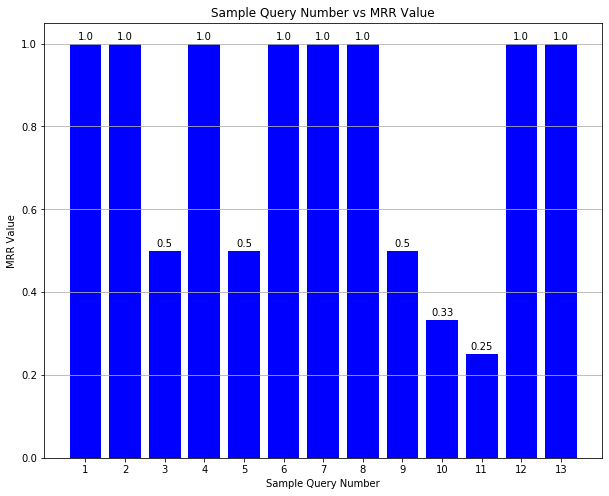

In [28]:
# 1. Bar Chart of Sample Query Number vs MRR Value
plt.figure(figsize=(10, 8))
bars1 = plt.bar(query_numbers, mrr_values, color='blue')
plt.title('Sample Query Number vs MRR Value')
plt.xlabel('Sample Query Number')
plt.ylabel('MRR Value')
plt.xticks(query_numbers)
plt.grid(axis='y')

# Adding value on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval+0.005, round(yval, 2), ha='center', va='bottom')

plt.show()

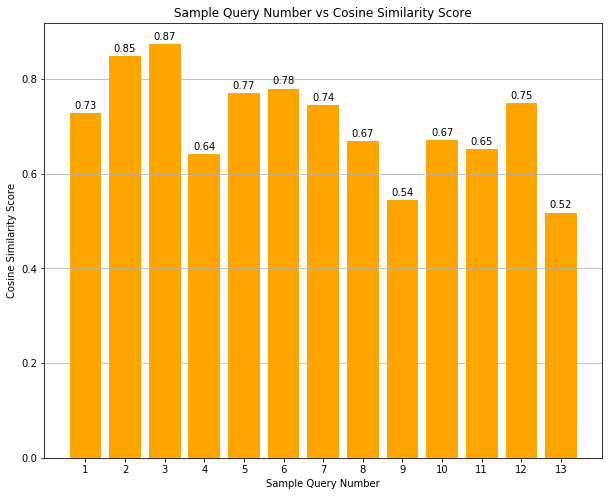

In [29]:
# 2. Bar Chart of Sample Query Number vs Cosine Similarity Score
plt.figure(figsize=(10, 8))
bars2 = plt.bar(query_numbers, cosine_similarity_scores, color='orange')
plt.title('Sample Query Number vs Cosine Similarity Score')
plt.xlabel('Sample Query Number')
plt.ylabel('Cosine Similarity Score')
plt.xticks(query_numbers)
plt.grid(axis='y')

# Adding value on top of each bar
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval+0.005, round(yval, 2), ha='center', va='bottom')

plt.show()

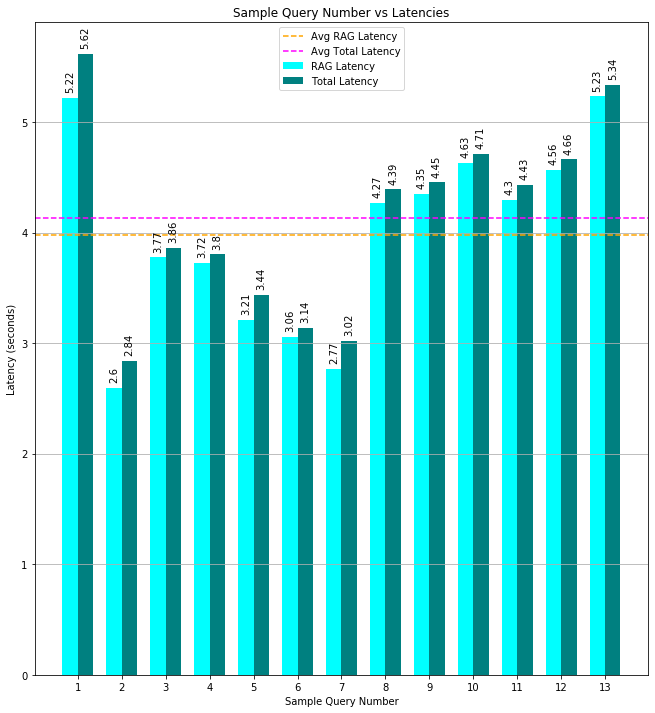

In [30]:
# 3. Bar Chart of Sample Query Number vs RAG Latency and Total Latency
bar_width = 0.35
x = np.arange(len(query_numbers))  # the label locations

plt.figure(figsize=(11, 12))
bars3 = plt.bar(x - bar_width/2, rag_latencies, bar_width, label='RAG Latency', color='cyan')
bars4 = plt.bar(x + bar_width/2, total_latencies, bar_width, label='Total Latency', color='teal')

# Adding average line
average_rag_latency = np.mean(rag_latencies)
average_total_latency = np.mean(total_latencies)
plt.axhline(y=average_rag_latency, color='orange', linestyle='--', label='Avg RAG Latency')
plt.axhline(y=average_total_latency, color='magenta', linestyle='--', label='Avg Total Latency')

plt.title('Sample Query Number vs Latencies')
plt.xlabel('Sample Query Number')
plt.ylabel('Latency (seconds)')
plt.xticks(x, query_numbers)
plt.legend()
    
# Adding value on top of each bar with vertical orientation and added offset of 0.5
for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', rotation=90)

for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', rotation=90)



plt.grid(axis='y')
plt.show()